<a href="https://colab.research.google.com/github/Wongel-Yilma/PINN-SR/blob/main/PINN_SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.io import loadmat
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 1)
        self.tanh = nn.Tanh()
        self.coefficients = torch.randn(16, requires_grad=True, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.tanh(self.fc5(x))
        return x

    def partial_derivatives(self, x, t):
        x = x.clone().detach().requires_grad_(True)
        t = t.clone().detach().requires_grad_(True)

        input_xt = torch.cat([x, t], dim=1)
        c_output = self.forward(input_xt)

        c_t = torch.autograd.grad(c_output, t, grad_outputs=torch.ones_like(c_output),
                                  create_graph=True, retain_graph=True)[0]
        c_x = torch.autograd.grad(c_output, x, grad_outputs=torch.ones_like(c_output),
                                  create_graph=True, retain_graph=True)[0]
        c_xx = torch.autograd.grad(c_x, x, grad_outputs=torch.ones_like(c_x),
                                  create_graph=True, retain_graph=True)[0]
        c_xxx = torch.autograd.grad(c_xx, x, grad_outputs=torch.ones_like(c_xx),
                                    create_graph=True, retain_graph=True)[0]

        return c_output, c_t, c_x, c_xx, c_xxx


    def physics_loss(self, c, c_t, c_x, c_xx, c_xxx):
        # Each term has shape (batch_size, 1)
        terms = [
            torch.ones_like(c), c, c**2, c**3,
            c_x, c * c_x, c**2 * c_x, c**3 * c_x,
            c_xx, c * c_xx, c**2 * c_xx, c**3 * c_xx,
            c_xxx, c * c_xxx, c**2 * c_xxx, c**3 * c_xxx,
        ]
        alpha = torch.std(c)/torch.std(c_t)

        Theta = torch.cat(terms, dim=1)

        coeffs = self.coefficients.unsqueeze(1)
        # print("Coefficients:": self.coefficients)

        f_pred = Theta @ coeffs

        p_loss = torch.mean((f_pred - c_t) ** 2)
        return p_loss, alpha





In [ ]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, X, c):
        self.X = X
        self.c = c

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.c[idx]

In [ ]:
class PINN_SR():
    def __init__(self, lr, epochs, batch_size, num_terms):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.criterion = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def fit(self, X, c, alpha_multiplier = 1e-10 ):
        """X is the input data, c is the output data"""
        self.X = torch.Tensor(X).float()
        self.c = torch.Tensor(c).float()
        self.shape = X.shape
        self.torch_module = PINN()
        self.torch_module.to(self.device)
        self.optimizer = torch.optim.Adam(self.torch_module.parameters(), lr=self.lr)
        dataset = MyDataset(self.X, self.c)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
        self.alpha_multiplier = alpha_multiplier

        for epoch in range(self.epochs):
            for i, data in enumerate(dataloader, 0):
                self.optimizer.zero_grad()
                self.train(data)
                self.optimizer.step()
            print("Epoch: {}; physics-loss {}; Data Loss: {} Total loss {}".format(epoch,self.p_loss, self.data_loss,self.loss))
            print("Alpha: ", self.alpha.item())
            print("coefficients:", self.torch_module.coefficients.detach().cpu().numpy())


    def train(self, batch):
        inputs, value = batch
        inputs, value = inputs.to(self.device), value.to(self.device)

        x = inputs[:, 0:1]
        t = inputs[:, 1:2]

        c_nn, c_t, c_x, c_xx, c_xxx = self.torch_module.partial_derivatives(x, t)
        self.p_loss, self.alpha = self.torch_module.physics_loss(c_nn, c_t, c_x, c_xx, c_xxx)
        self.data_loss = self.criterion(c_nn, value)
        self.loss = self.data_loss + self.alpha_multiplier*self.alpha*self.p_loss + 1e-3*self.torch_module.coefficients.norm()
        self.loss.backward()

    def predict(self, X):
        self.torch_module.eval()
        X = torch.Tensor(X).float()
        X = X.to(self.device)
        with torch.no_grad():
            outputs = self.torch_module(X)
        return outputs.cpu().numpy()






In [ ]:
data = loadmat('./MC_deposit.mat')['C']
nx, nt = data.shape
x = np.linspace(0,nx-1, nx)
t = np.linspace(0,nt-1, nt)
X, T = np.meshgrid(x, t,indexing='ij')
## Normalizing the input
X = X.reshape(-1,1)/(nx-1)
T = T.reshape(-1,1)/(nt-1)
c = data.reshape(-1,1)/(data.max()-data.min())
idx = np.random.permutation(len(X))[:5000]
X = X[idx]
T = T[idx]
c = c[idx]
pinn_sr = PINN_SR(lr = 0.0005,epochs= 4, batch_size=32, num_terms=16)
pinn_sr.fit(np.hstack((X,T)), c)

Epoch: 0; physics-loss 48.84178924560547; Data Loss: 0.00048178969882428646 Total loss 0.003955048508942127
Alpha:  0.591905951499939
coefficients: [-1.0896176  -0.19812076 -0.20752843 -0.27831927  1.2164279   0.45477083
 -0.5251858   0.63923836 -1.789248   -1.0151426  -0.5429536  -0.41563052
 -0.34704012  0.40002486  1.8241519   0.19504248]
Epoch: 1; physics-loss 152.5885009765625; Data Loss: 0.00014035464846529067 Total loss 0.003613614710047841
Alpha:  0.260738730430603
coefficients: [-1.0896176  -0.19812076 -0.20752843 -0.27831927  1.2164279   0.45477083
 -0.5251858   0.63923836 -1.789248   -1.0151426  -0.5429536  -0.41563052
 -0.34704012  0.40002486  1.8241519   0.19504248]
Epoch: 2; physics-loss 63.471988677978516; Data Loss: 9.761033288668841e-05 Total loss 0.0035708663053810596
Alpha:  0.009230691939592361
coefficients: [-1.0896176  -0.19812076 -0.20752843 -0.27831927  1.2164279   0.45477083
 -0.5251858   0.63923836 -1.789248   -1.0151426  -0.5429536  -0.41563052
 -0.34704012  

In [ ]:
pinn_sr.fit(np.hstack((X,T)), c, alpha_multiplier = 1 )

Epoch: 0; physics-loss 1.7796686887741089; Data Loss: 0.006396458484232426 Total loss 5.2901387214660645
Alpha:  2.9667091369628906
coefficients: [-1.2970878   0.02873969 -1.6318754  -0.7042799   0.11182649 -0.09922749
  1.5128274  -0.97479546 -0.8334289  -0.5878489  -1.6002969  -0.9483009
 -1.2164749  -1.0039506   0.5810474  -0.6596548 ]


In [ ]:
def Plot3D(A,title='3D plot',zlim=0,cutBoundary=False):
    shape= np.shape(A)
    cutDist = 50
    nx = shape[0]
    ny = shape[1]
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator
#     import i
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    y = np.linspace(0,nx-1,nx)
    x = np.linspace(0,(ny-1),ny)
    [X,Y] =np.meshgrid(x,y)
    np.shape(X)


    if cutBoundary ==True:
        surf = ax.plot_surface(X[cutDist:nx-cutDist,4:ny-4], Y[cutDist:nx-cutDist,4:ny-4], A[cutDist:nx-cutDist,4:ny-4], cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    else:
        surf = ax.plot_surface(X, Y, A, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(r'Time $t$',rotation=-30)
    ax.set_ylabel(r'Position $x$')
    #ax.set_zlabel('Concentration')
    ax.set_title(title)
    if zlim!=0:
        ax.set_zlim3d(-zlim,zlim)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    # plt.savefig(title+'.png')
    return



In [ ]:
x_test = np.linspace(0,nx-1, nx)
t_test = np.linspace(0,nt-1, nt)
X_test, T_test = np.meshgrid(x_test, t_test,indexing='ij')
X_test = X_test.reshape(-1,1)/(nx-1)
T_test = T_test.reshape(-1,1)/(nt-1)
c_pred = pinn_sr.predict(np.hstack((X_test,T_test)))
C_pred  = c_pred.reshape(nx, nt)

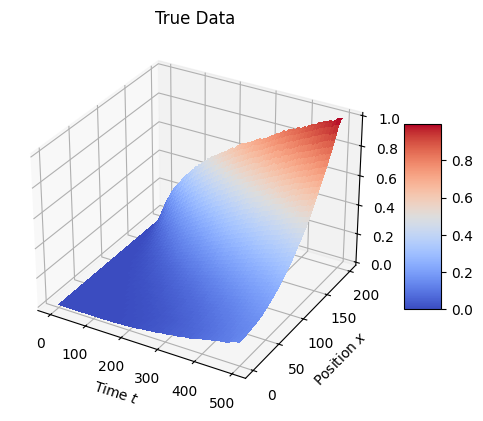

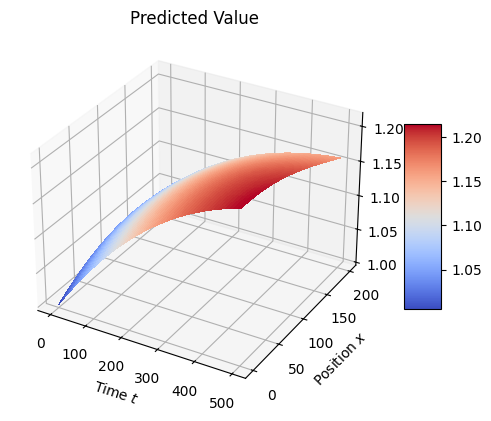

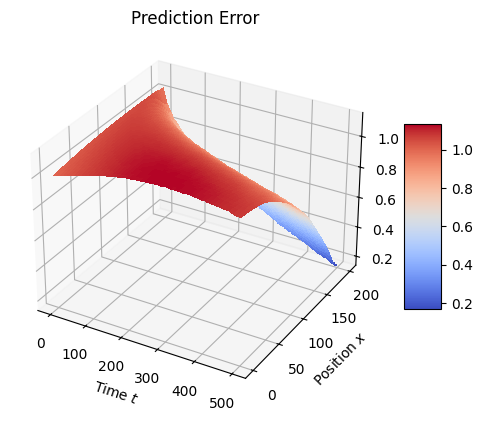

In [ ]:
# C_pred.shape
Plot3D(data/(data.max()),'True Data')
Plot3D(C_pred/(C_pred.max()),'Predicted Value')
Plot3D(-data/data.max()+C_pred/(C_pred.max()),'Prediction Error')
